In [252]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import linsolve
import uvtools
import pyuvdata
import glob
from astropy.io import fits
from pygsm import GSMObserver
from scipy import interpolate
from datetime import datetime
from astropy.time import Time
import healpy as hp
from log_progress import log_progress
from scipy.ndimage import filters
from astropy import constants as const
import os
from hera_qm import xrfi
from hera_qm import utils as qm_utils
import copy

In [53]:
class TskySim():
    """ Class to run Tsky Simulations"""
    def __init__(self, Tsky_file=None, beam_file=None, df=1.0, f_min=100.0, f_max=200.0, dlst=0.5,
                 pols=['E', 'N'], lat=-30.7224, lon=21.4278, elev=1100):
        """
        Initialize class
        Args:
            Tsky_file: Filename of npz file calculated from this class
            beam_file: Filename of fits file with beam
            df: channel width (MHz)
            f_min: minimum frequency (MHz)
            f_max: maximum frequency (MHz)
            dlst: LST separation (hours) Note, assume simulating 24 hours.
            pols: Polarizations
            lat: Latitude (degrees)
            lon: Longitude (degrees)
            elev: Elevation (feet?)
        """
        self.Tsky_file = Tsky_file
        self.beam_file = beam_file
        self.df = df
        self.f_min = f_min
        self.f_max = f_max
        self.dlst = dlst
        self.pols = pols
        self.lat = lat
        self.lon = lon
        self.elev = elev
        
        if self.Tsky_file is None:
            self.Tsky = None
            self.update_options()
        else:
            self.read_Tsky()

    def update_options(self):
        self.freqs = np.arange(self.f_min, self.f_max + self.df / 2.0, self.df)
        self.hours = np.arange(0.0, 24.0, self.dlst)
        self.lsts = np.zeros_like(self.hours)
        
    def read_Tsky(self):
        d = np.load(self.Tsky_file)
        self.freqs = d['freqs']
        self.lsts = d['lsts']
        self.Tsky = d['Tsky']
        self.pols = d['pols']
        try:
            self.Ae = d['Ae']
        except KeyError:
            print('Warning: Effective area not read from file.')

    def write_Tsky(self):
        np.savez(self.Tsky_file, Tsky=self.Tsky, freqs=self.freqs, lsts=self.lsts, pols=self.pols, Ae=self.Ae)
        
    def calc_Tsky(self):
        """
        Calculate the Tsky sim based on beam file and the GSM
        """
        if self.beam_file is None:
            raise(ValueError('Beam file is not defined, cannot compute Tsky simulation.'))
        # Otherwise go ahead and calculate
        self.Tsky = np.zeros((len(self.pols), len(self.freqs), len(self.lsts)))
        
        # First set up beam
        beam = {}
        rot_pol = {}
        temp_f = fits.getdata(self.beam_file, extname='FREQS')
        for i, pol in enumerate(self.pols):
            try:
                im = fits.getdata(self.beam_file, extname='BEAM_{0}'.format(pol))
                rot_pol[pol] = False
            except KeyError:
                # My example file only has one pol, need to rotate it (later)
                im = fits.getdata(self.beam_file, extname='BEAM_{0}'.format(self.pols[1 - i]))
                rot_pol[pol] = True
            func = interpolate.interp1d(temp_f, im, kind='cubic', axis=1)
            beam[pol] = func(self.freqs)
            
        # Get the effective area
        self.Ae = np.array((len(self.pols), len(self.freqs)))
        for poli, pol in enumerate(self.pols):
            self.Ae[poli] = ((const.c.to('m*MHz').value / self.freqs)**2. /
                             (4 * np.pi / im.shape[0] * np.sum(beam[pol], axis=0) /
                              np.max(beam[pol], axis=0)))
        
        # Set up observer
        ov = GSMObserver()
        ov.lon = str(self.lon)
        ov.lat = str(self.lat)
        ov.elev = self.elev
        
        fig = plt.figure('Tsky_calc')  # Never found a way to not open a figure...
        for poli, pol in enumerate(self.pols):
            for fi, freq in enumerate(log_progress(self.freqs, every=1, name='Pol ' + pol + ', Freqs')):
                if rot_pol[pol]:
                    pol_ang = 0.0
                else:
                    pol_ang = 90.0
                temp_beam = hp.orthview(beam[pol][:, fi], rot=[pol_ang, 90], fig=fig.number,
                                        xsize=400, return_projected_map=True, half_sky=True)
                temp_beam[np.isinf(temp_beam)] = np.nan
                for ti, t in enumerate(self.hours):
                    plt.clf()
                    dt = datetime(2013, 1, 1, np.int(t), np.int(60.0 * (t - np.floor(t))),
                                  np.int(60.0 * (60.0 * t - np.floor(t * 60.0))))
                    self.lsts[ti] = Time(dt).sidereal_time('apparent', self.lon).hour
                    ov.date = dt
                    ov.generate(freq)
                    d = ov.view(fig=fig.number)
                    sky = hp.orthview(d, fig=fig.number, xsize=400, return_projected_map=True, half_sky=True)
                    sky[np.isinf(sky)] = np.nan
                    self.Tsky[poli, fi, ti] = np.nanmean(temp_beam * sky) / np.nanmean(temp_beam)
        
        inds = np.argsort(self.lsts)
        self.lsts = self.lsts[inds]
        self.Tsky = self.Tsky[:, :, inds]
        
    def build_model(self, buffer=10):
        """
        Create interpolation model for calculating Tsky and Ae at any frequency/LST.
        
        Args:
            buffer: (int) size of wrapping buffer to avoid edge effects in LST interpolation.
        """
        # Pad to avoid edge effects
        temp_lsts = np.concatenate([self.lsts[-buffer:] - 24., self.lsts, Tsky_sim.lsts[:buffer] + 24.])
        temp_Tsky = np.concatenate([self.Tsky[:, :, -buffer:], self.Tsky, Tsky_sim.Tsky[:, :, :buffer]], axis=2)
        self.mdl = {}
        self.mdlAe = {}
        for poli, pol in enumerate(self.pols):
            self.mdl[pol] = interpolate.RectBivariateSpline(self.freqs, temp_lsts, temp_Tsky[poli, :, :])
            self.mdlAe[pol] = interpolate.interp1d(self.freqs, self.Ae[poli])

In [344]:
class auto_data():
    """ Class to hold auto correlation data """
    def __init__(self, data_dir='/data6/HERA/data/2458042/KM_uvR_files/', filestart='zen.*',
                 dpols=['xx', 'yy'], fileend='*.uvR', autos_file='IDR1_autos.uvR'):
        self.data_dir = data_dir
        self.autos_file = autos_file
        self.dpols = dpols
        self.pol_map = {'xx': 'E', 'yy': 'N'}
        self.pols = np.array([self.pol_map[p] for p in self.dpols])
        self.rev_pol_map = {'E': 'xx', 'N': 'yy'}
        # Read in data
        self.filestart = filestart
        self.fileend = fileend
        self.read_data()
        
    def read_data(self, force_read=False):
        self.uv = pyuvdata.UVData()
        if os.path.exists(self.data_dir + self.autos_file) and not force_read:
            self.uv.read_miriad(self.data_dir + self.autos_file)
        else:
            file_lists = []
            for pol in self.pols:
                file_lists.append(np.sort(glob.glob(self.data_dir + self.filestart +
                                                    self.rev_pol_map[pol] + self.fileend)))
            if len(file_lists[0]) != len(file_lists[1]):
                print('File list lengths are not the same!')
            uv_temp = pyuvdata.UVData()
            for i in log_progress(range(len(file_lists[0])), every=1, name='Reading Obs'):
                if i == 0:
                    self.uv.read_miriad([file_lists[0][i], file_lists[1][i]])
                    self.uv.select(ant_str='auto')
                else:
                    uv_temp.read_miriad([file_lists[0][i], file_lists[1][i]])
                    uv_temp.select(ant_str='auto')
                    self.uv += uv_temp
            self.uv.write_miriad(self.data_dir + self.autos_file)
            
        # Get some useful parameters
        self.lsts, ind = np.unique(self.uv.lst_array, return_index=True)
        order = np.argsort(ind)
        self.lsts = 24 * self.lsts[order] / (2 * np.pi)
        self.wrap = np.argmax(self.lsts)
        self.freqs = self.uv.freq_array.flatten() * 1e-6
        self.ants = self.uv.get_ants()
    
    def build_model(self, sim):
        """
        Build model of Tsky that matches the data
        Args:
            sim: TskySim object with interpolation model already built
        """
        self.Tsky = np.zeros((len(self.pols), len(self.lsts), len(self.freqs)))
        self.Ae = np.zeros((len(self.pols), len(self.freqs)))
        self.Tsky_mean = np.zeros((len(self.pols), len(self.freqs)))
        for poli, pol in enumerate(self.pols):
            self.Tsky[poli, :, :] = np.concatenate([sim.mdl[pol](self.freqs, self.lsts[:self.wrap + 1]),
                                                    sim.mdl[pol](self.freqs, self.lsts[self.wrap + 1:])], axis=1).T
            self.Tsky_mean[poli, :] = self.Tsky[poli, :, :].mean(axis=0)
            self.Ae[poli, :] = sim.mdlAe[pol](self.freqs)
    
    def _fits2gTrxr(self, all_chans=True, ch=600):
        """ Quick function to get from linear solution to physical parameters."""
        if all_chans:
            Ae = self.Ae
        else:
            Ae = self.Ae[:, ch]
        for ant, pol in self.fits.keys():
            poli = np.where(self.pols == pol)[0][0]
            self.gains[(ant, pol)] = np.sqrt(Ae[poli] / 2761.3006 * self.fits[(ant, pol)][0])
            self.Trxr[(ant, pol)] = self.fits[(ant, pol)][1] / self.fits[(ant, pol)][0] - self.Tsky_mean[poli]
    
    def fit_data(self, all_chans=True, ch=600):
        """
        Fit gains and receiver temperatures based on LST evolution of signal fit to
        simulated Tsky.
        
        Args:
            all_chans: (bool) fit all channels if set to True (default, slow). 
                       Otherwise only fit channel ch (faster).
            ch:        (int) Only fit this channel number. Default 600.
                       Ignored if all_chans == True.
        """
        
        self.gains = {}
        self.Trxr = {}
        self.fits = {}
        for poli, pol in enumerate(self.pols):
            for ant in log_progress(self.ants, every=1, name='Ant'):
                data = np.abs(self.uv.get_data((ant, ant, self.rev_pol_map[pol])))
                flags = self.uv.get_flags((ant, ant, self.rev_pol_map[pol]))
                d_ls = {}
                w_ls = {}
                kwargs = {}
                for i in range(self.lsts.size):
                    if all_chans:
                        # Solve for all channels at once
                        d_ls['Tsky%d*g+n' % i] = data[i, :]
                        w_ls['Tsky%d*g+n' % i] = 1 - flags[i, :]
                        kwargs['Tsky%d' % i] = self.Tsky[poli, i, :] - self.Tsky_mean[poli]
                    else:
                        # Only solve channel ch
                        d_ls['Tsky%d*g+n' % i] = data[i, ch]
                        w_ls['Tsky%d*g+n' % i] = 1 - flags[i, ch]
                        kwargs['Tsky%d' % i] = self.Tsky[poli, i, ch] - self.Tsky_mean[poli]
                ls = linsolve.LinearSolver(d_ls, w_ls, **kwargs)
                sol = ls.solve()
                self.fits[(ant, pol)] = (sol['g'], sol['n'])
        self._fits2gTrxr(all_chans=all_chans, ch=ch)
    
    def data2Tsky(self, key):
        poli = np.where(self.pols == key[1])[0]
        d = self.uv.get_data((key[0], key[0], self.rev_pol_map[key[1]]))
        d = d / ((self.gains[key]**2. * 2761.3006 / self.Ae[poli]).reshape(1, -1)) - self.Trxr[key]
        return d

## 1. Create Tsky sim
Use precomputed Tsky vs LST if available, otherwise generate it.

In [54]:
recalculate = False
Tsky_file = '/data4/beards/HERA_IDR1_analysis/HERA_Tsky_22Feb2018.npz'
hera_beam_file = '/home/beards/code/HERA-Beams/NicolasFagnoniBeams/healpix_beam.fits'
if recalculate:
    Tsky_sim = TskySim(beam_file=hera_beam_file)
    Tsky_sim.calc_Tsky()
    # Save data for future runs
    Tsky_sim.Tsky_file = Tsky_file
    Tsky_sim.write_Tsky()
else:
    Tsky_sim = TskySim(Tsky_file=Tsky_file, beam_file=hera_beam_file)

<IPython.core.display.Javascript object>


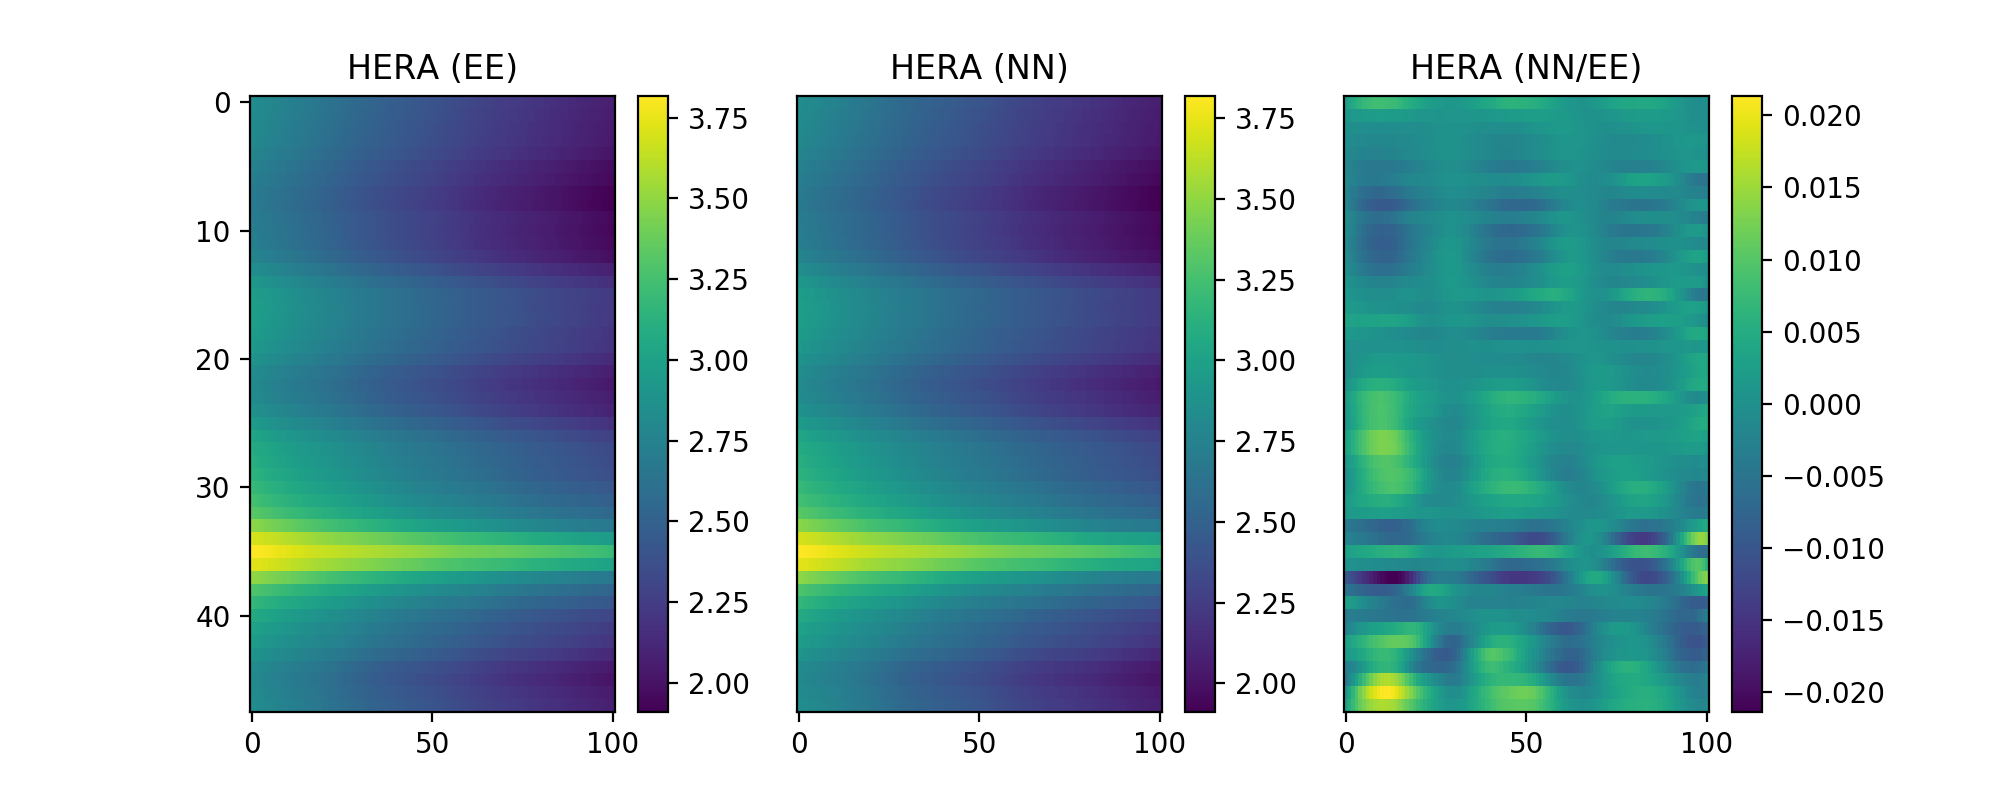

In [55]:
# Plot the Tsky sim
plt.figure(figsize = (10, 4))
plt.subplot(131)
uvtools.plot.waterfall(Tsky_sim.Tsky[0, :, :].T)
plt.colorbar()
plt.title('HERA (' + Tsky_sim.pols[0] + Tsky_sim.pols[0] + ')')

plt.subplot(132)
uvtools.plot.waterfall(Tsky_sim.Tsky[1, :, :].T)
plt.colorbar()
plt.title('HERA (' + Tsky_sim.pols[1] + Tsky_sim.pols[1] + ')')
plt.yticks([])

plt.subplot(133)
uvtools.plot.waterfall(Tsky_sim.Tsky[1, :, :].T / Tsky_sim.Tsky[0, :, :].T)
plt.colorbar()
plt.title('HERA (' + 2*Tsky_sim.pols[1] + '/' + 2*Tsky_sim.pols[0] + ')')
plt.yticks([])

plt.show()

In [56]:
# Build interpolation models
Tsky_sim.build_model()

In [345]:
IDR1_H1C_data = auto_data(data_dir='/data6/HERA/data/2458042/KM_uvR_files/', filestart='zen.*',
                          fileend='*.uvR', autos_file='IDR1_autos.uvR')
IDR1_H1C_data.build_model(Tsky_sim)

<IPython.core.display.Javascript object>


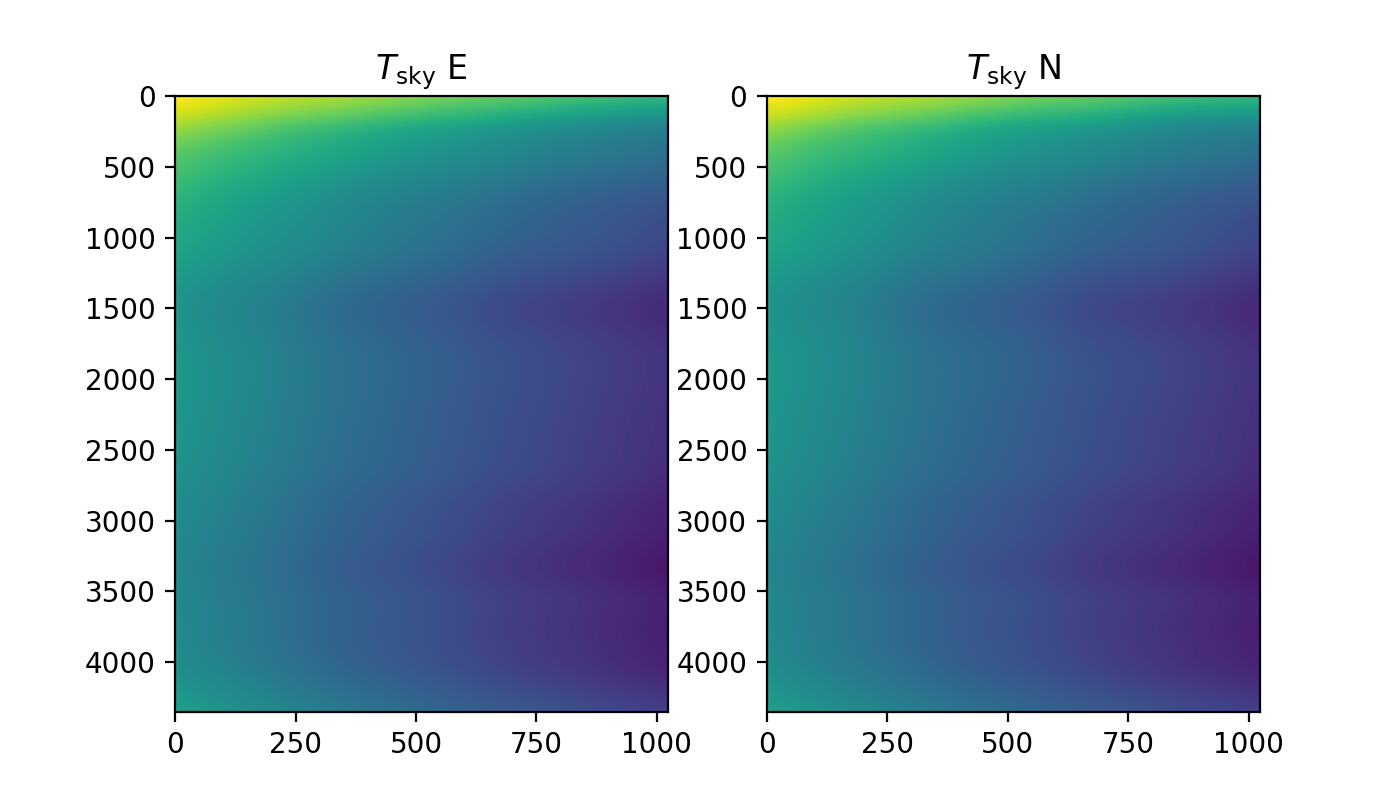

<IPython.core.display.Javascript object>


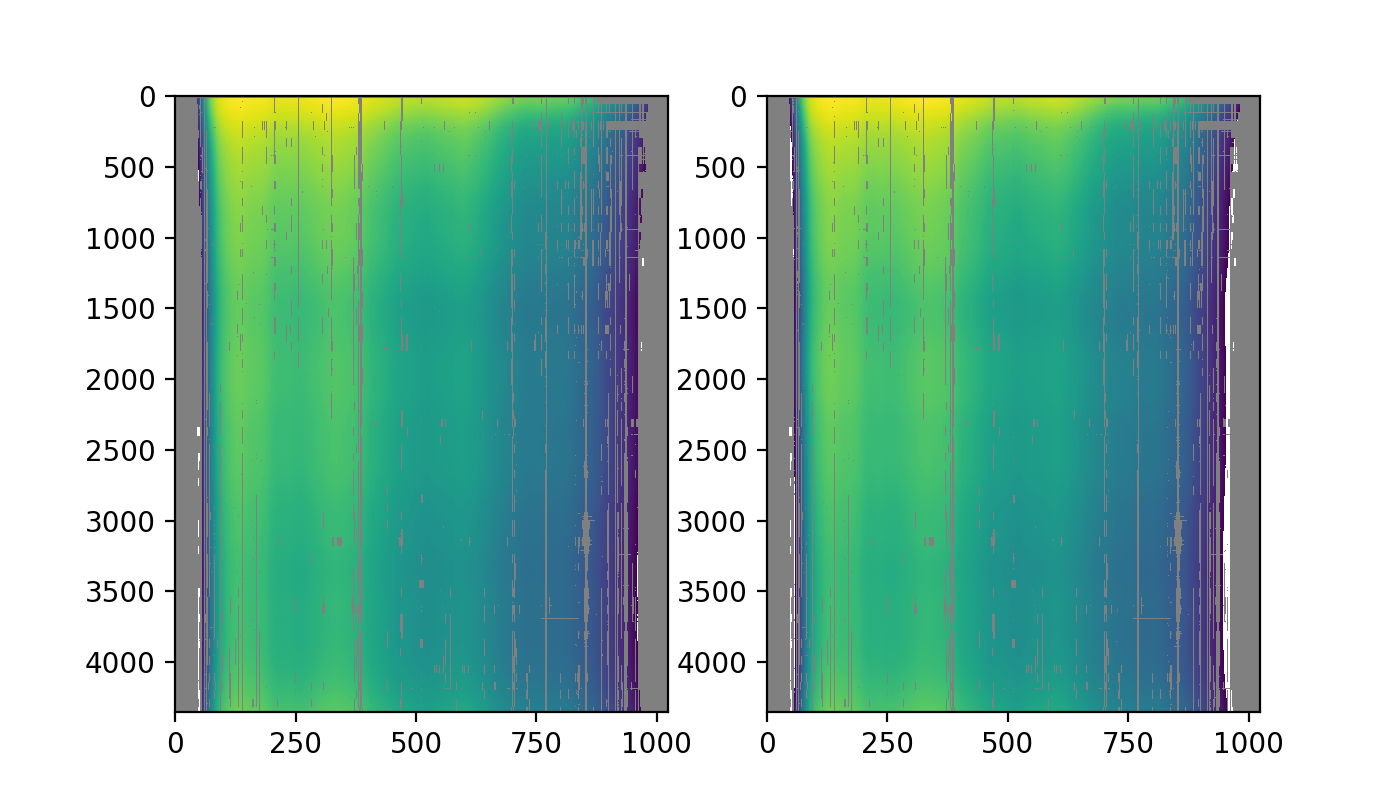

In [346]:
# Plot
chosen_ant = 24  # corresponds to ant9 from H19, which I plotted in memo
plt.figure(figsize=(7, 4))
for poli, pol in enumerate(IDR1_H1C_data.pols):
    plt.subplot(1, 2, poli + 1)
    uvtools.plot.waterfall(IDR1_H1C_data.Tsky[poli], drng=2)
    plt.title('$T_{\\rm sky}$ ' + pol)

# Compare with a baseline
plt.figure(figsize=(7, 4))
for poli, pol in enumerate(Tsky_sim.pols):
    plt.subplot(1, 2, poli + 1)
    data = np.ma.masked_where(IDR1_H1C_data.uv.get_flags((chosen_ant, chosen_ant, IDR1_H1C_data.rev_pol_map[pol])),
                              IDR1_H1C_data.uv.get_data((chosen_ant, chosen_ant, IDR1_H1C_data.rev_pol_map[pol])))
    uvtools.plot.waterfall(data, drng=2)

<IPython.core.display.Javascript object>


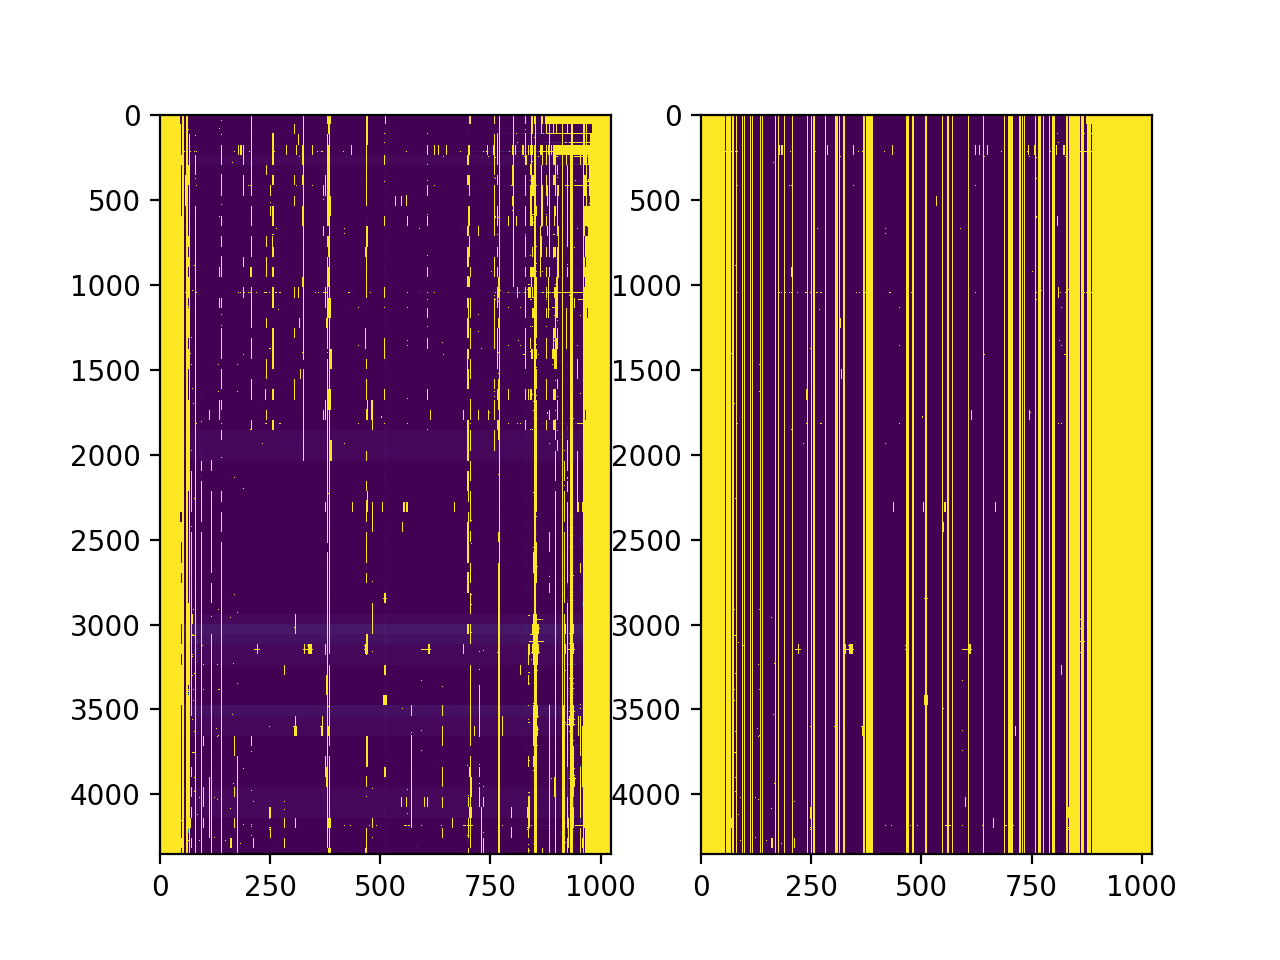

In [347]:
# Do some more flagging
# I noticed that running xrfi didn't add anything,
# So here I will just do another broadcasting round, with the benefit of more time
a = qm_utils.get_metrics_ArgumentParser('xrfi_run')
args = a.parse_args('')  # use defaults for now
# flag_array = xrfi.vis_flag(IDR1_H1C_data.uv, args)
# compare current and prior flags
wf = xrfi.flags2waterfall(IDR1_H1C_data.uv, flag_array=IDR1_H1C_data.uv.flag_array)
# This ends up being really aggressive, but I'm curious to see what it looks like.
wf_t = xrfi.threshold_flags(wf, px_threshold=args.px_threshold,
                            freq_threshold=args.freq_threshold,
                            time_threshold=args.time_threshold)
plt.figure()
plt.subplot(121)
plt.imshow(wf, aspect='auto')
plt.subplot(122)
plt.imshow(wf_t, aspect='auto')
flags_original = copy.deepcopy(IDR1_H1C_data.uv.flag_array)
IDR1_H1C_data.uv.flag_array = xrfi.waterfall2flags(wf_t, IDR1_H1C_data.uv)

In [348]:
IDR1_H1C_data.fit_data()

invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in

<IPython.core.display.Javascript object>


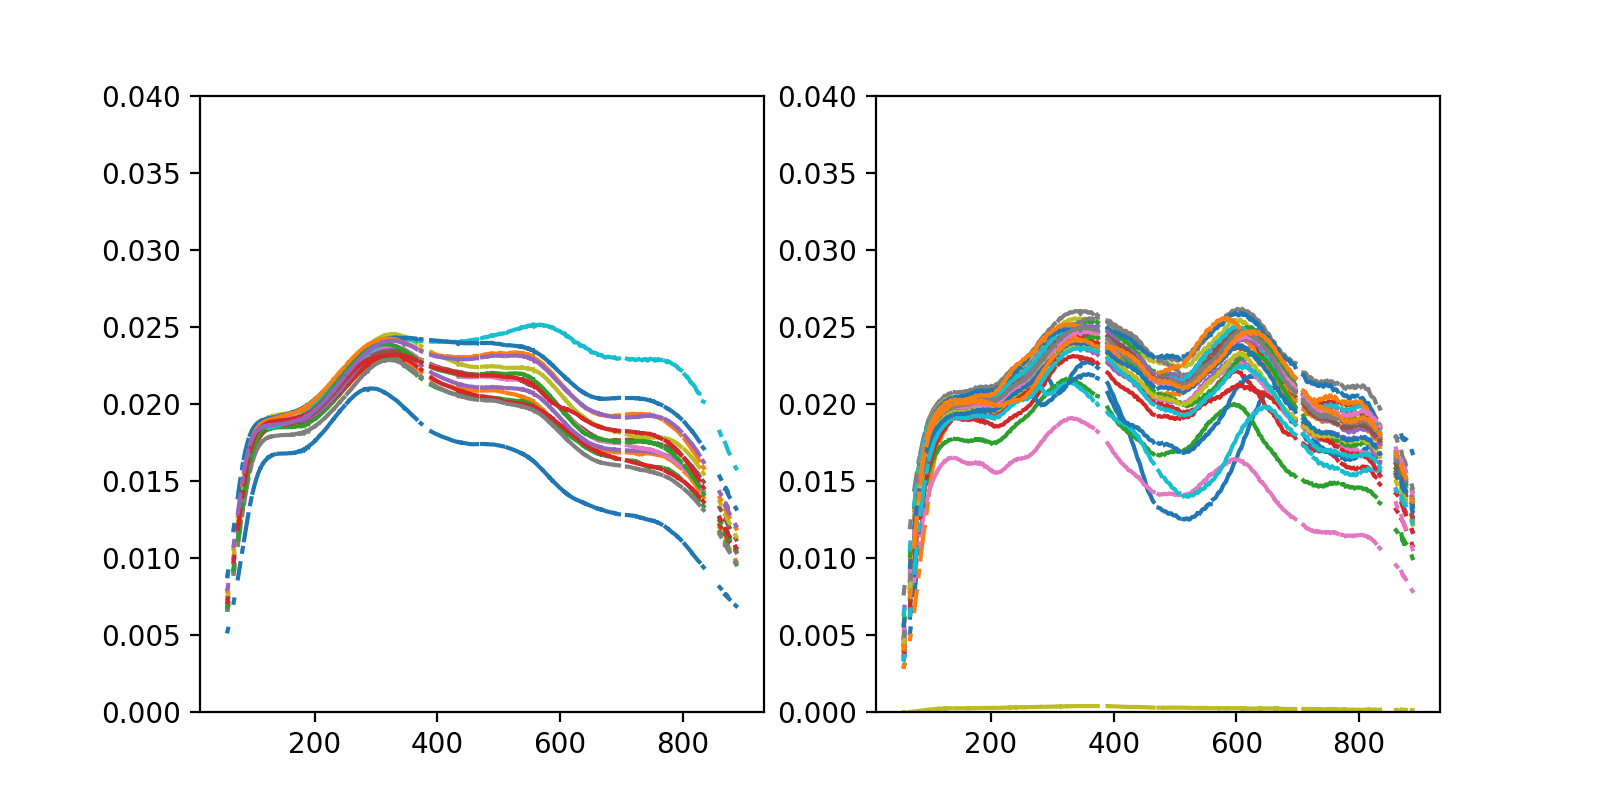

In [358]:
plt.figure(figsize=(8,4))
nrao_list = [51, 65, 66, 70, 82, 83, 98, 120, 121, 122, 123, 124, 141, 142, 143]
for ant in IDR1_H1C_data.ants:
    if ant in nrao_list:
        plt.subplot(121)
    else:
        plt.subplot(122)
    #plt.plot(filters.gaussian_filter1d(IDR1_H1C_data.gains[(ant, 'E')], 5))
    g = IDR1_H1C_data.gains[(ant, 'E')]
    g = np.where(g == 0, np.nan, g)
    plt.plot(g)
plt.subplot(121)
plt.ylim([0, .04])
plt.subplot(122)
plt.ylim([0, .04]);

<IPython.core.display.Javascript object>


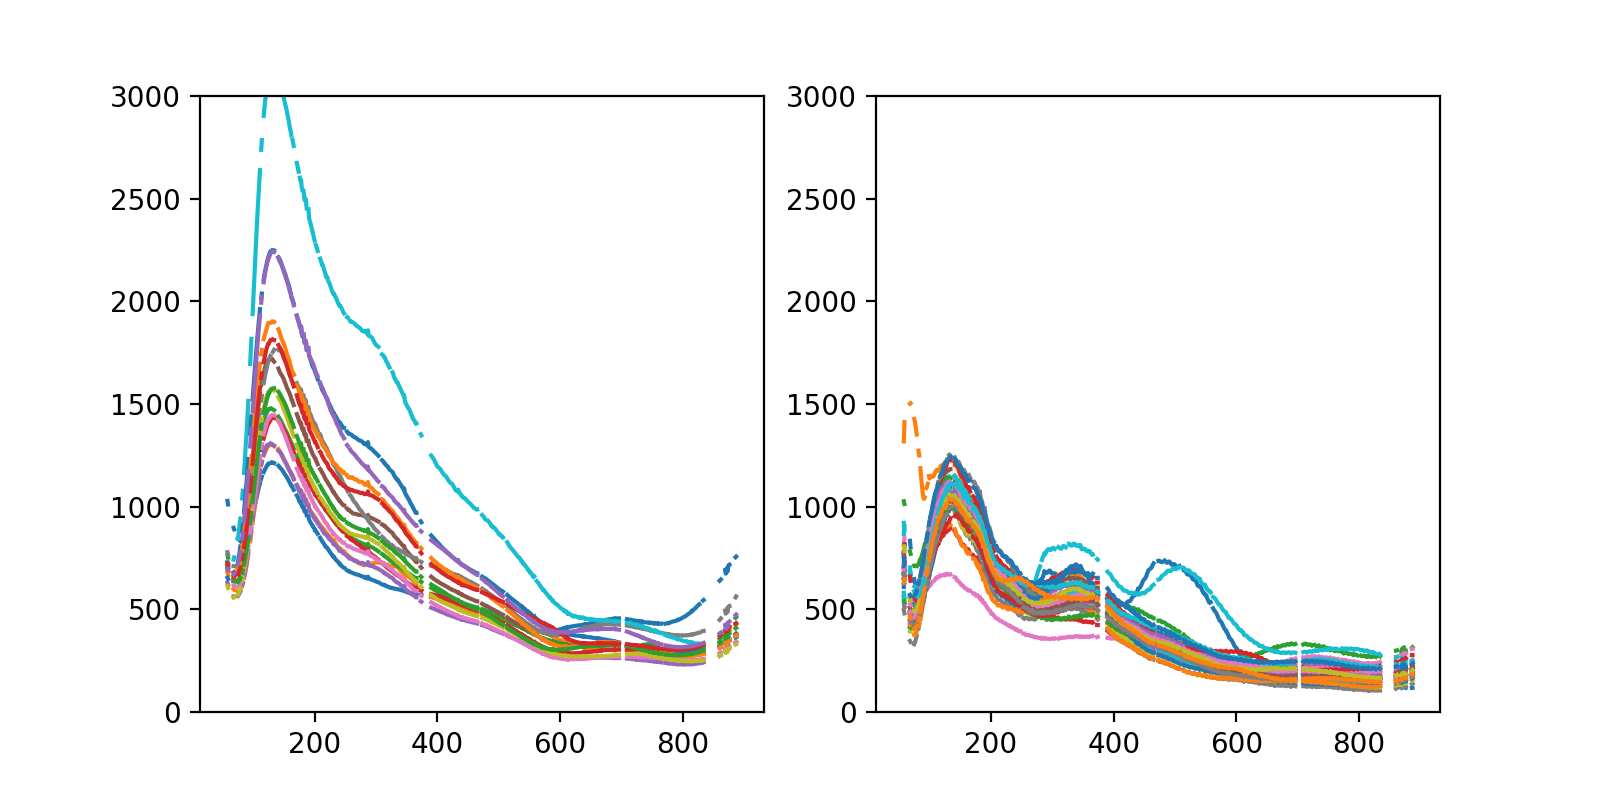

In [373]:
plt.figure(figsize=(8,4))
for ant in IDR1_H1C_data.ants:
    if ant in nrao_list:
        plt.subplot(121)
    else:
        plt.subplot(122)
    t = IDR1_H1C_data.Trxr[(ant, 'E')]
    t = np.where(t==0, np.nan, t)
    plt.plot(t)
plt.subplot(121)
plt.ylim([0, 3e3])
plt.subplot(122)
plt.ylim([0, 3e3]);

<IPython.core.display.Javascript object>


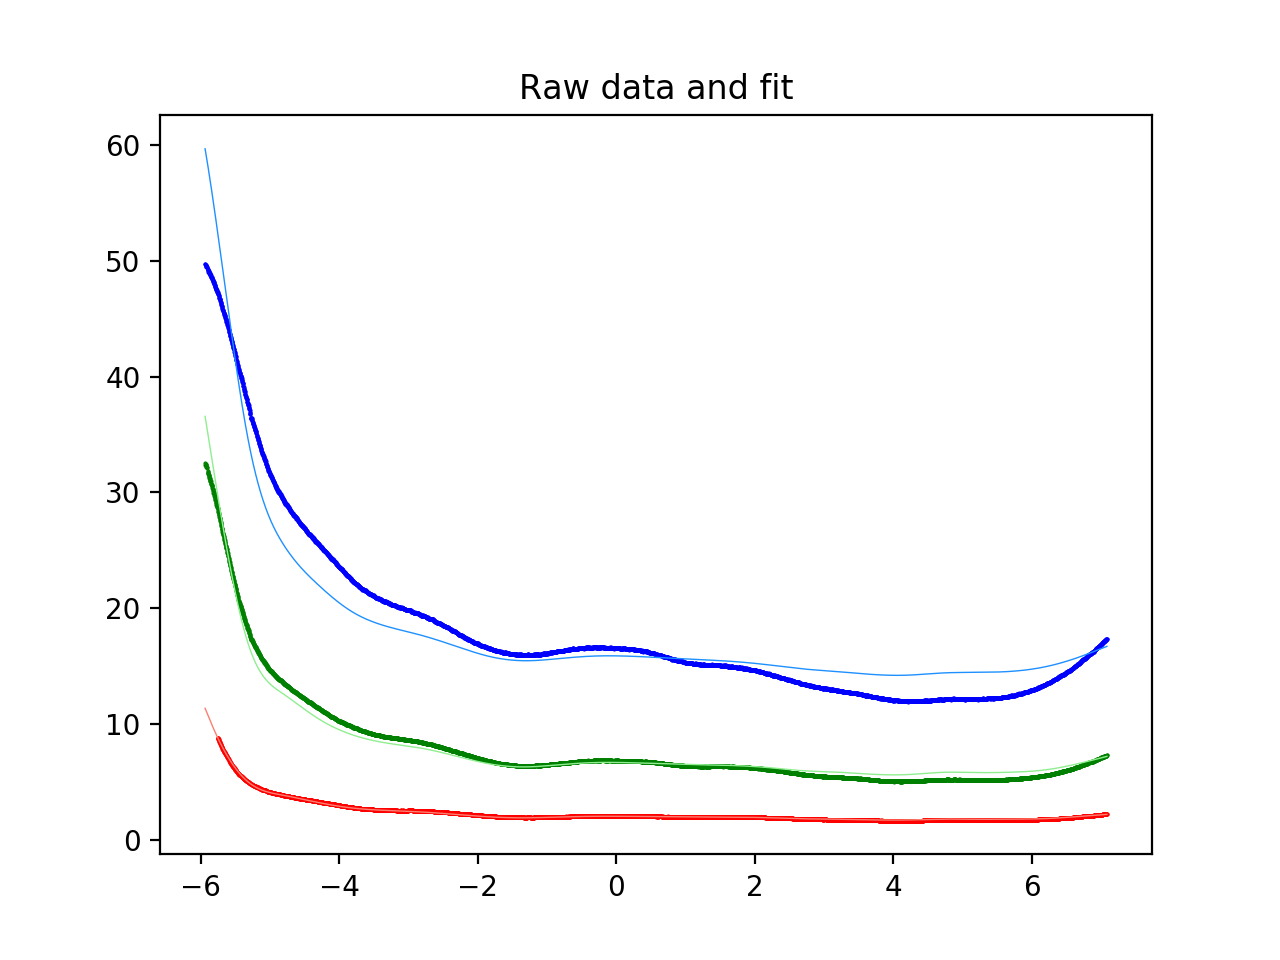

Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


In [374]:
# Plot data vs corrupted Tsky
plt.figure()
chosen_ant = 24
dark_colors = ['blue', 'green', 'red']
light_colors = ['dodgerblue', 'lightgreen', 'salmon']
poli = 0
pol = IDR1_H1C_data.pols[poli]
chans = [166, 520, 872]  # Correspond to what's plotted in memo
d = np.ma.masked_where(IDR1_H1C_data.uv.get_flags((chosen_ant, chosen_ant, IDR1_H1C_data.rev_pol_map[pol])),
                       IDR1_H1C_data.uv.get_data((chosen_ant, chosen_ant, IDR1_H1C_data.rev_pol_map[pol])))
plot_lsts = np.concatenate([IDR1_H1C_data.lsts[:(IDR1_H1C_data.wrap+1)]-24, IDR1_H1C_data.lsts[(IDR1_H1C_data.wrap+1):]])
for i, chan in enumerate(chans):
    d_plot = d[:, chan]
    plt.plot(plot_lsts, d_plot, '.', ms=1, color=dark_colors[i])
    mdl_plot = ((IDR1_H1C_data.Tsky[poli, :, chan] - IDR1_H1C_data.Tsky_mean[poli][chan]) *
                IDR1_H1C_data.fits[(chosen_ant, pol)][0][chan] + IDR1_H1C_data.fits[(chosen_ant, pol)][1][chan])
    plt.plot(plot_lsts, mdl_plot, linewidth=0.5, color=light_colors[i])
plt.title('Raw data and fit');

<IPython.core.display.Javascript object>


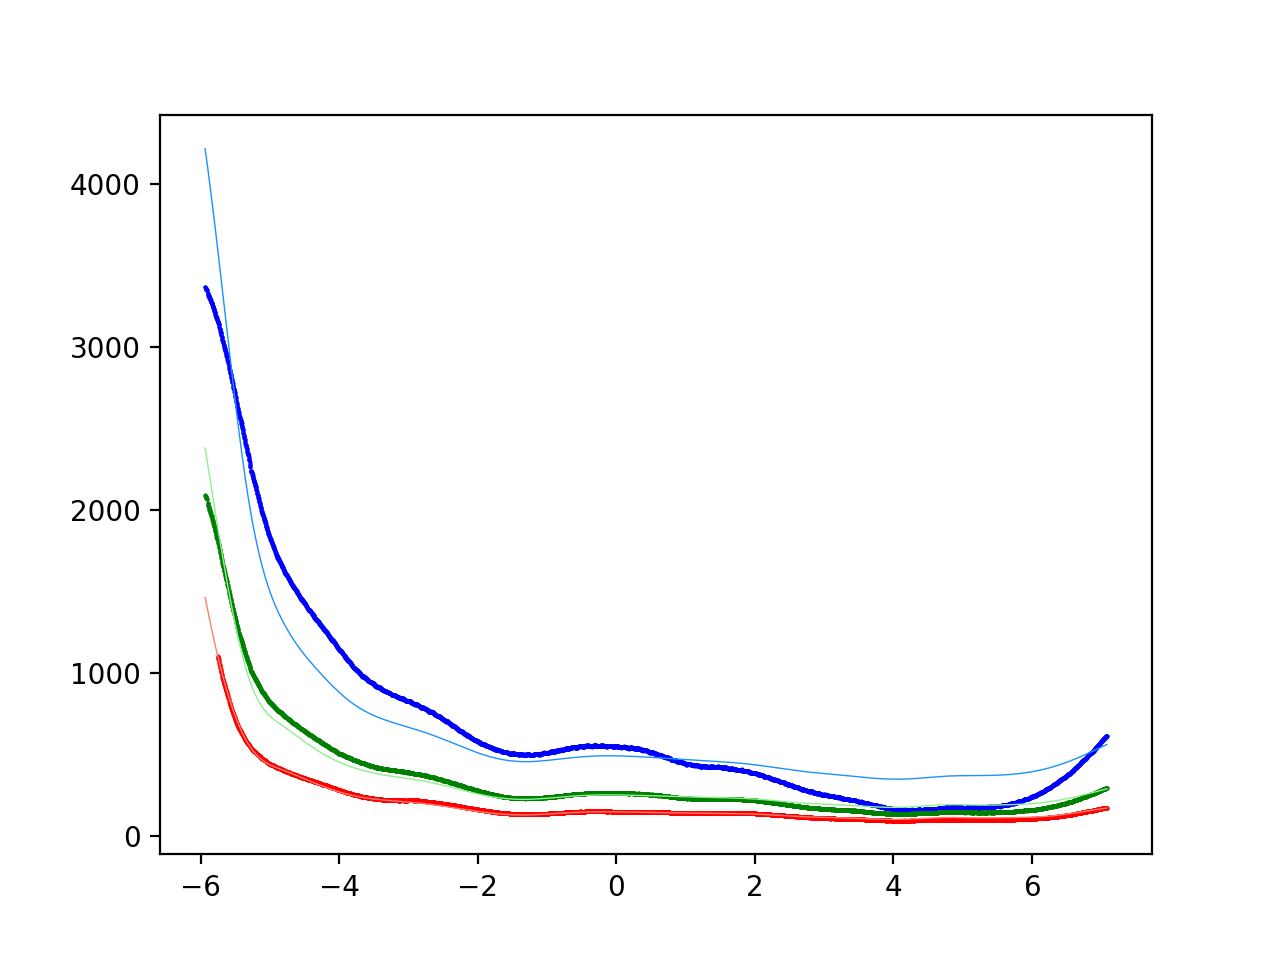

divide by zero encountered in divide
invalid value encountered in divide
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part
Casting complex values to real discards the imaginary part


In [375]:
# Plot estimate for Tsky
plt.figure()
chosen_ant = 24
dark_colors = ['blue', 'green', 'red']
light_colors = ['dodgerblue', 'lightgreen', 'salmon']
poli = 0
pol = IDR1_H1C_data.pols[poli]
chans = [166, 520, 872]  # Correspond to what's plotted in memo
d = np.ma.masked_where(IDR1_H1C_data.uv.get_flags((chosen_ant, chosen_ant, IDR1_H1C_data.rev_pol_map[pol])),
                       IDR1_H1C_data.data2Tsky((chosen_ant, pol)))
plot_lsts = np.concatenate([IDR1_H1C_data.lsts[:(IDR1_H1C_data.wrap+1)]-24, IDR1_H1C_data.lsts[(IDR1_H1C_data.wrap+1):]])
for i, chan in enumerate(chans):
    d_plot = d[:, chan]
    plt.plot(plot_lsts, d_plot, '.', ms=1, color=dark_colors[i])
    mdl_plot = IDR1_H1C_data.Tsky[poli, :, chan]
    plt.plot(plot_lsts, mdl_plot, linewidth=0.5, color=light_colors[i])

In [376]:
# Run for H0C
IDR1_H0C_data = auto_data(data_dir='/data6/HERA/data/2457458/', filestart='zen.*',
                          fileend='*.uvHH', autos_file='IDR1_autos.uvHH')
IDR1_H0C_data.build_model(Tsky_sim)

<IPython.core.display.Javascript object>


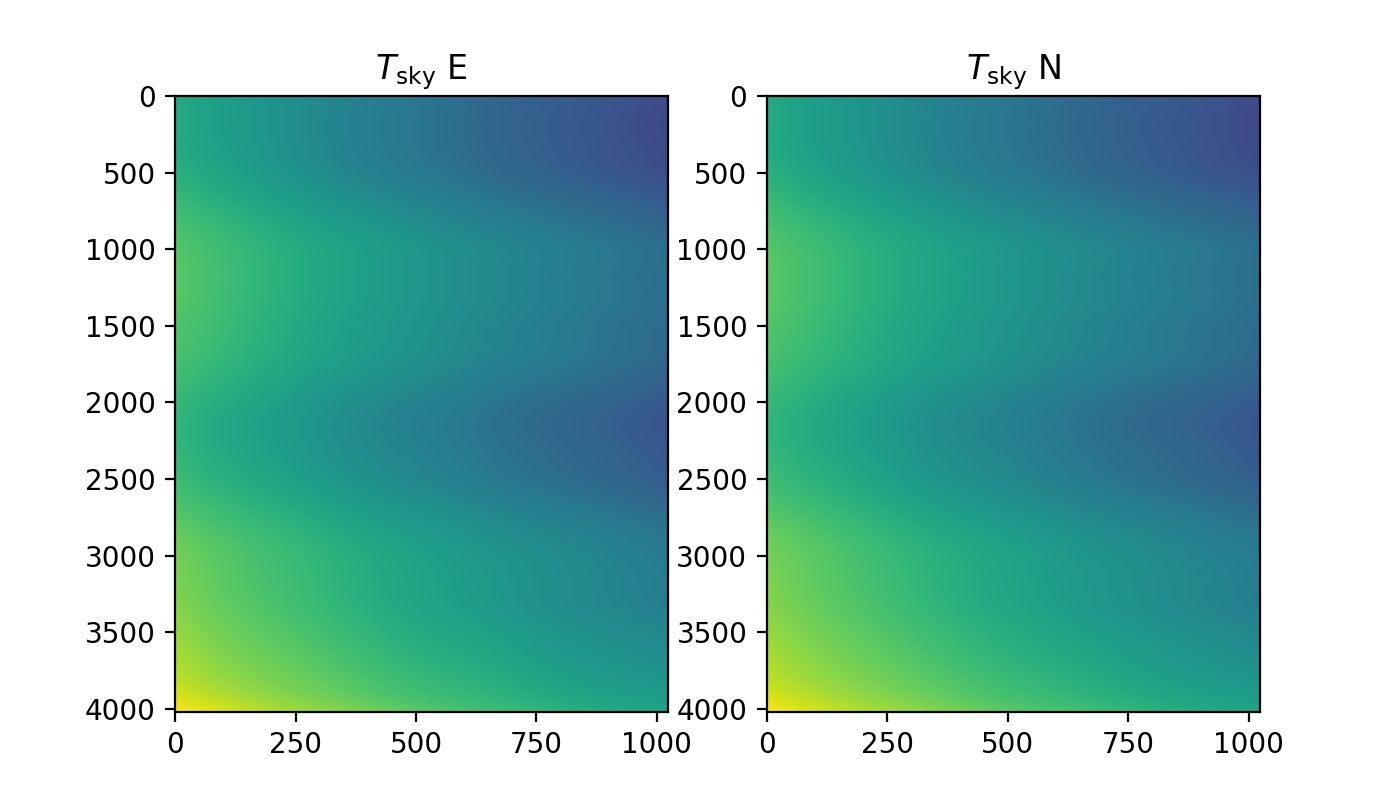

<IPython.core.display.Javascript object>


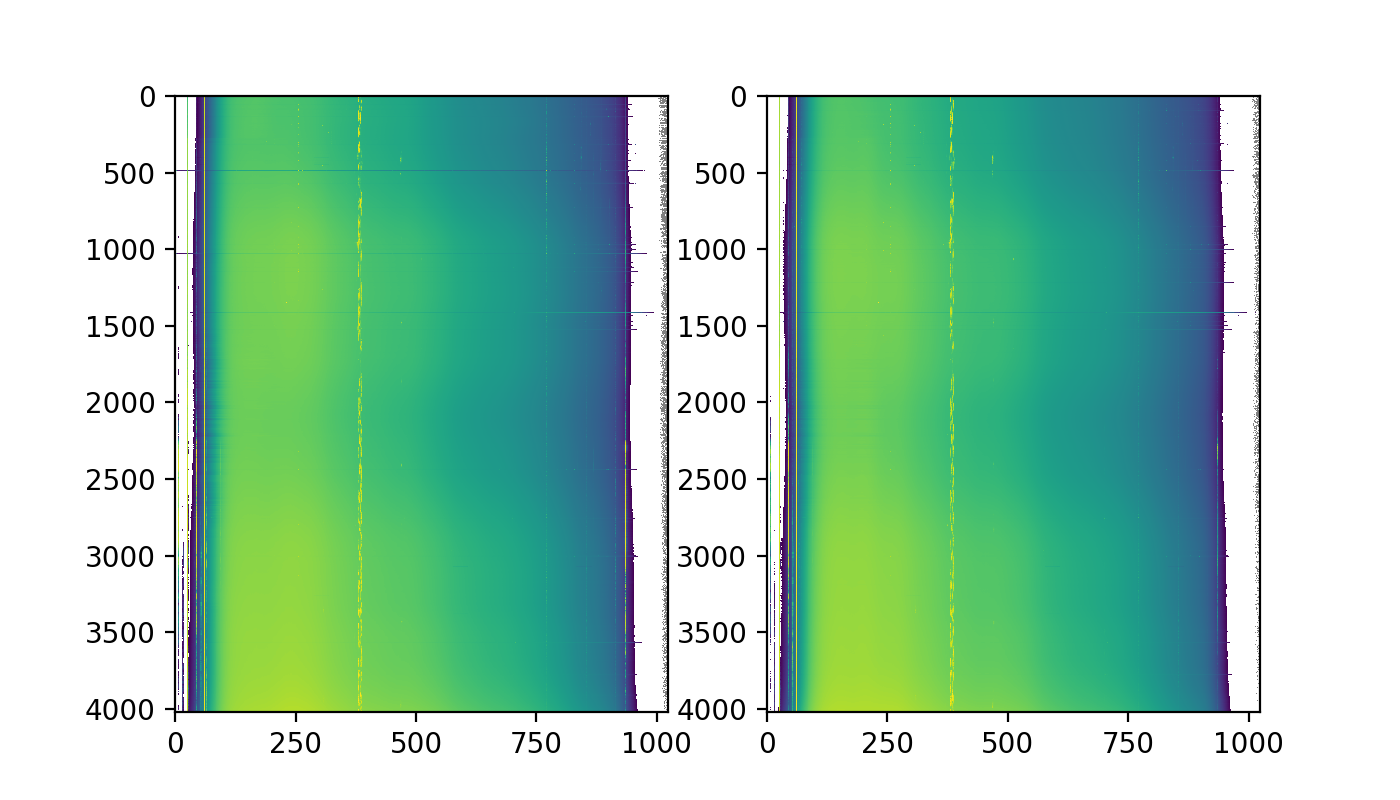

In [377]:
# Plot
chosen_ant = 9
plt.figure(figsize=(7, 4))
for poli, pol in enumerate(IDR1_H0C_data.pols):
    plt.subplot(1, 2, poli + 1)
    uvtools.plot.waterfall(IDR1_H0C_data.Tsky[poli], drng=2)
    plt.title('$T_{\\rm sky}$ ' + pol)

# Compare with a baseline
plt.figure(figsize=(7, 4))
for poli, pol in enumerate(Tsky_sim.pols):
    plt.subplot(1, 2, poli + 1)
    data = np.ma.masked_where(IDR1_H0C_data.uv.get_flags((chosen_ant, chosen_ant, IDR1_H0C_data.rev_pol_map[pol])),
                              IDR1_H0C_data.uv.get_data((chosen_ant, chosen_ant, IDR1_H0C_data.rev_pol_map[pol])))
    uvtools.plot.waterfall(data, drng=2)

divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater
divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater
divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater
divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater
divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater
divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater
divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater
divide by zero encountered in true_divide
invalid value encountered in true_divide
invalid value encountered in greater
divide by zero encountered in true_divid

<IPython.core.display.Javascript object>


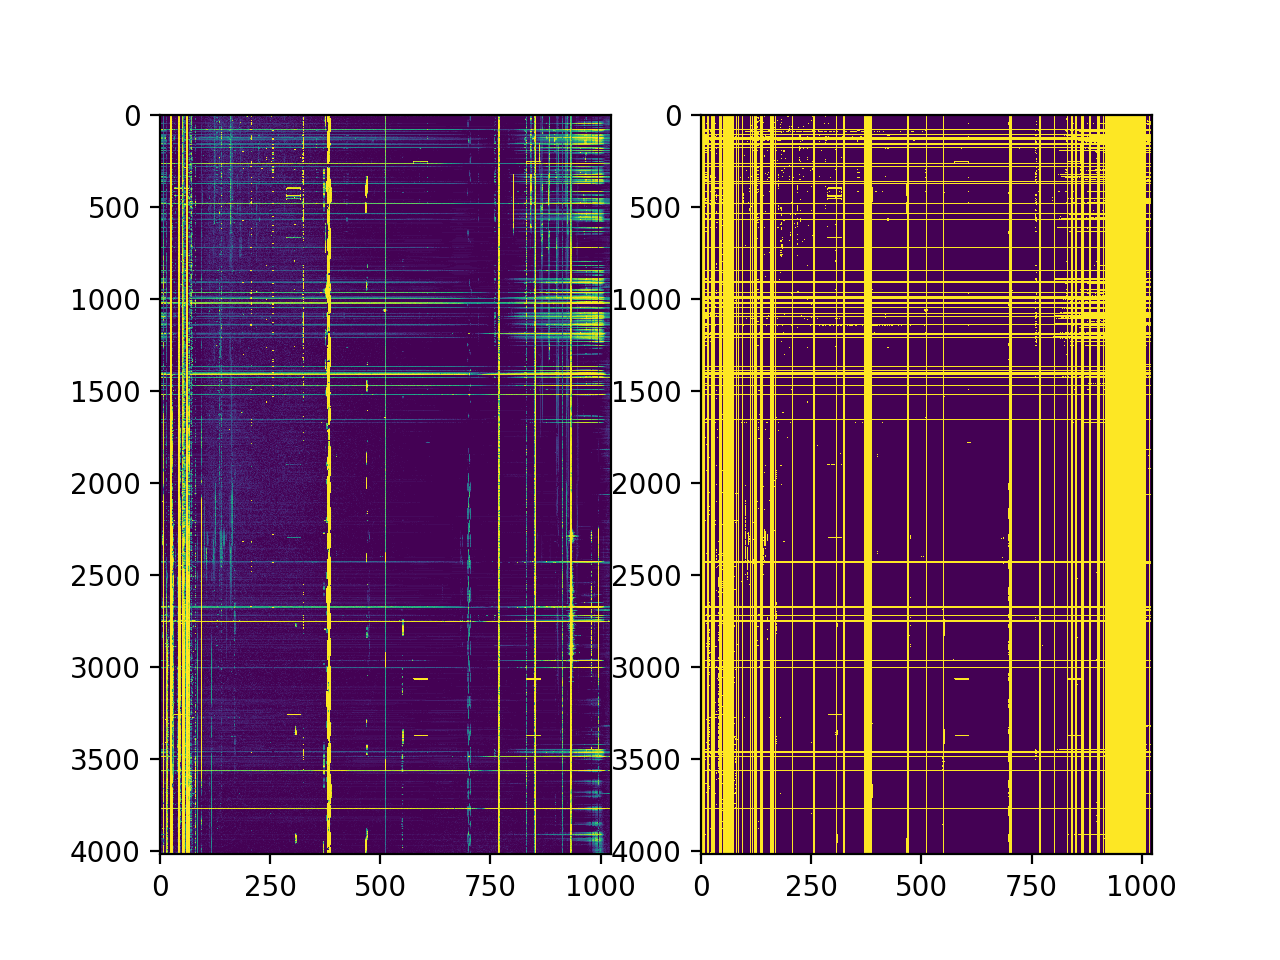

In [378]:
# reload(xrfi)
# Do some flagging
a = qm_utils.get_metrics_ArgumentParser('xrfi_run')
args = a.parse_args('')  # use defaults for now
IDR1_H0C_data.uv.flag_array = flags_original0
flag_array = xrfi.vis_flag(IDR1_H0C_data.uv, args)
wf = xrfi.flags2waterfall(IDR1_H0C_data.uv, flag_array=flag_array)
# This ends up being really aggressive, but I'm curious to see what it looks like.
wf_t = xrfi.threshold_flags(wf, px_threshold=args.px_threshold,
                            freq_threshold=0.5*args.freq_threshold,
                            time_threshold=2*args.time_threshold)
plt.figure()
plt.subplot(121)
plt.imshow(wf, aspect='auto')
plt.subplot(122)
plt.imshow(wf_t, aspect='auto')
flags_original0 = copy.deepcopy(IDR1_H0C_data.uv.flag_array)
IDR1_H0C_data.uv.flag_array = xrfi.waterfall2flags(wf_t, IDR1_H0C_data.uv)

In [379]:
IDR1_H0C_data.fit_data()

invalid value encountered in sqrt
invalid value encountered in divide
invalid value encountered in sqrt
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in sqrt
invalid value encountered in divide
invalid value encountered in sqrt
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in sqrt
invalid value encountered in divide
invalid value encountered in sqrt
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in sqrt
invalid value encountered in divide
invalid value encountered in sqrt
invalid value encountered in divide
invalid value encountered in sqrt
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in sqrt
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid value encountered in divide
invalid valu

<IPython.core.display.Javascript object>


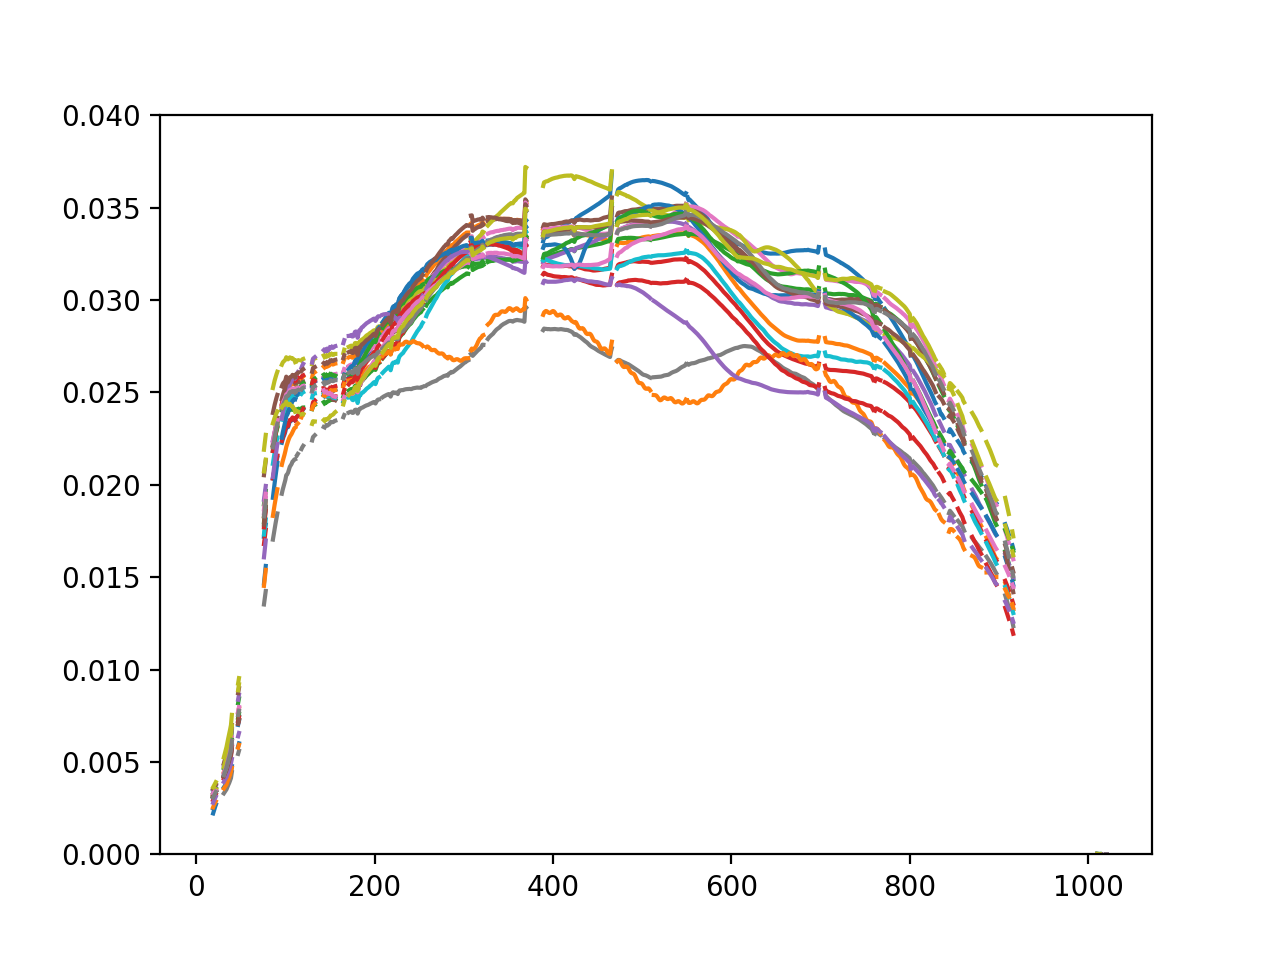

(0, 0.04)

In [380]:
plt.figure()
for ant in IDR1_H0C_data.ants:
    g = IDR1_H0C_data.gains[(ant, 'E')]
    g = np.where(g==0, np.nan, g)
    plt.plot(g)
    #plt.plot(IDR1_H0C_data.gains[(ant, 'E')])
plt.ylim([0, .04])

<IPython.core.display.Javascript object>


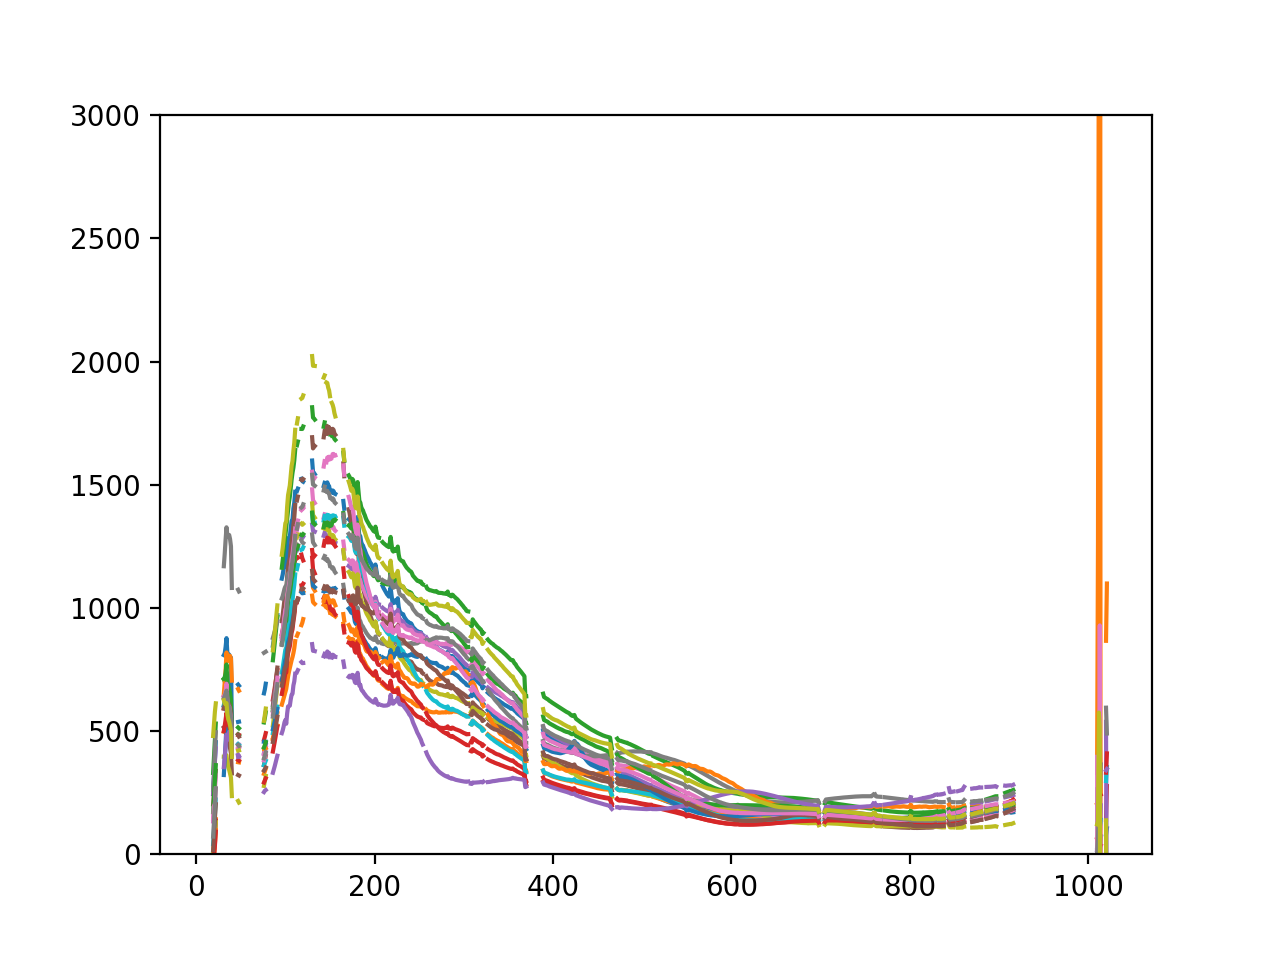

In [381]:
plt.figure()
for ant in IDR1_H0C_data.ants:
    t = IDR1_H0C_data.Trxr[(ant, 'E')]
    t = np.where(t==0, np.nan, t)
    #plt.plot(filters.gaussian_filter1d(IDR1_H0C_data.Trxr[(ant, 'E')], 5))
    plt.plot(t)
plt.ylim([0, 3e3]);